In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import typing

In [2]:
%autoreload
from src.xes.load_xes import load_raw_xes
from src.xes.xes_file import XesFile
from src.xes.print_xes_info import PrintXesInfo
import src.utils
import src.xes.analyze_sequence

In [3]:
xes = XesFile.read("data/Activities of daily living of several individuals_1_all/data/edited_hh102_labour.xes/edited_hh102_labour.xes")
PrintXesInfo.s_print_info(xes)

Traces: 18, events: 1152
Events: Average: 64.0, Min: 46, Max: 82

4 unique attributes in events:
           Attribute  Count Presence
        concept:name   1151    99.9%
lifecycle:transition   1151    99.9%
      time:timestamp   1151    99.9%
            Column_4   1151    99.9%

"time:timestamp": 99.9% presence
average:      2011-06-27 07:57:20.849826560+00:00
min:          2011-06-14 22:06:32+00:00
max:          2011-07-09 04:55:29+00:00
average span: 1 days 00:26:16.333333333

"concept:name": 99.9% presence, 18 different values, top 5:
relax (190), personalhygiene (154), toilet (152), sleep (120), snack (84)

"lifecycle:transition": 99.9% presence, 2 different values, top 2:
start (576), complete (576)

"Column_4": 99.9% presence, 18 different values, top 5:
relax (190), personalhygiene (154), toilet (152), sleep (120), snack (84)


In [4]:
# First trace
df = xes.traces[0].df

# Filtered trace
df = df[df["lifecycle:transition"] == "complete"]

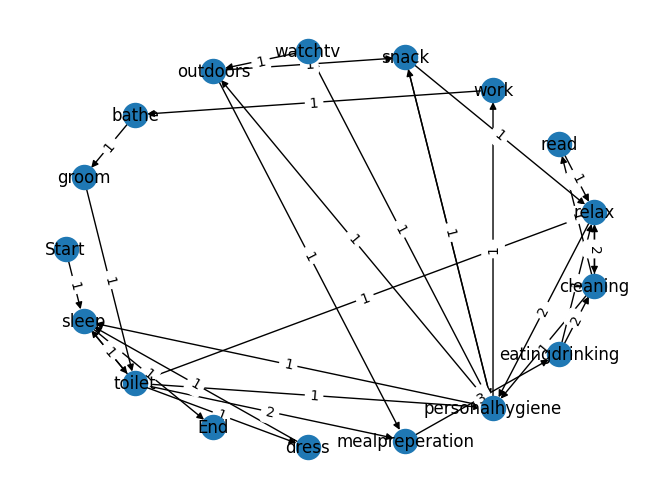

In [191]:
sequence = src.xes.analyze_sequence.analyze_sequence(
    df,
    sequence_keys=["concept:name"])
src.xes.analyze_sequence.draw_nx_graph(sequence)

In [17]:
src.utils.choice(sequence['Start, start'])

'Start, complete'

In [6]:
generated = [next(iter(sequence))]
for i in range(10):
    event = generated[i]

    if not event in sequence: break

    next_event = src.utils.choice(sequence[event])
    generated.append(next_event)
generated

['Start',
 'sleep',
 'toilet',
 'sleep',
 'toilet',
 'mealpreperation',
 'eatingdrinking',
 'cleaning',
 'personalhygiene',
 'sleep',
 'toilet']

In [20]:
# {
#     "start": {
#         "weight": 10,
#         "children": {
#             "a": {
#                 "weight": 20,
#                 "children": {
#                     "b": {
#                         "weight": 30,
#                         "children": {}
#                     }
#                 }
#             }
#         }
#     }
# }

example_sequence = {
    "a": {"b": 5, "c": 10},
    "b": {"c": 10, "a": 20},
}

def expand_weighted_tree(
        sequence,
        current_node: str,
        min_depth: int,
        max_depth: int,
        end_nodes: list[str] = [],
        current_depth: int = 0,
        ) -> dict:
    if current_depth > max_depth: return None
    if current_node not in sequence: return {}

    children = sequence[current_node]

    if current_depth < min_depth:
        children = {key: children[key] for key in children if key not in end_nodes}

    result = {}
    for child in children:
        weight = children[child]

        children_of_child = expand_weighted_tree(
            sequence=sequence,
            current_node=child,
            end_nodes=end_nodes,
            min_depth=min_depth,
            max_depth=max_depth,
            current_depth=current_depth + 1
        )

        if children_of_child is None: continue
        if len(children_of_child) == 0 and current_depth < min_depth: continue

        children_of_child = {key: children_of_child[key]
                             for key in children_of_child
                             if len(children_of_child[key]) > 0}

        result[child] = {"weight": weight, "children": children_of_child}

    return result

r = expand_weighted_tree(sequence=example_sequence,
                     current_node="a",
                    #  end_nodes=["c"],
                     min_depth=5,
                     max_depth=10)
r

{'b': {'weight': 5,
  'children': {'a': {'weight': 20,
    'children': {'b': {'weight': 5,
      'children': {'a': {'weight': 20,
        'children': {'b': {'weight': 5,
          'children': {'c': {'weight': 10, 'children': {}},
           'a': {'weight': 20,
            'children': {'b': {'weight': 5,
              'children': {'c': {'weight': 10, 'children': {}},
               'a': {'weight': 20,
                'children': {'b': {'weight': 5,
                  'children': {'c': {'weight': 10, 'children': {}},
                   'a': {'weight': 20, 'children': {}}}},
                 'c': {'weight': 10, 'children': {}}}}}},
             'c': {'weight': 10, 'children': {}}}}}}}}}}}}}}}

In [30]:
import yaml
print(yaml.dump(r))

b:
  children:
    a:
      children:
        b:
          children:
            a:
              children:
                b:
                  children:
                    a:
                      children:
                        b:
                          children:
                            a:
                              children:
                                b:
                                  children:
                                    a:
                                      children: {}
                                      weight: 20
                                    c:
                                      children: {}
                                      weight: 10
                                  weight: 5
                                c:
                                  children: {}
                                  weight: 10
                              weight: 20
                            c:
                              children: {}
             

In [24]:
import ete3

In [29]:
def to_tree(d: dict[str, dict]):
    tree = ete3.Tree(name=d["name"])

    if "children" not in d: return tree

    for i in d["children"]:
        tree.add_child(to_tree(i))

    return tree

t = to_tree(
    {
        "name": "a",
        "children": [
            {
                "name": "b",
                "children": [
                    {
                        "name": "c",
                    },
                    {
                        "name": "e",
                    },
                    {
                        "name": "f",
                    }
                ]
            },
            {
                "name": "d"
            }
        ]
    }
)

print(t.get_ascii())


      /-c
     |
   /b|--e
  |  |
-a|   \-f
  |
   \-d


In [95]:
def expand_node_children(
        sequence: dict[str, dict[str, float]],
        current_node_name: str,
        min_steps: int,
        max_steps: int,
        end_nodes: list[str] = [],
        current_step: int = 0,
        ) -> list[dict]:
    if current_node_name not in sequence: return []
    if current_step > max_steps: return []

    next_nodes = sequence[current_node_name]

    children = []
    for next_node_name, next_node_weight in next_nodes.items():
        next_node_children = expand_node_children(
            sequence=sequence,
            current_node_name=next_node_name,
            end_nodes=end_nodes,
            min_steps=min_steps,
            max_steps=max_steps,
            current_step=current_step + 1
        )

        # If we are near recursion limit...
        if current_step >= max_steps - 1:
            # Then all nodes in `next_node_children` will have empty "children" array (because of 2 early returns at the
            # start of the method). "children" array will be empty for nodes that are either "sinks" or just hit
            # max_steps. So filter out nodes that hit max_steps. In other words, include only "sinks". PS: In directed
            # graph, node without outcoming connections is called "sink":
            # https://en.wikipedia.org/wiki/Glossary_of_graph_theory
            next_node_children = [child for child in next_node_children if child["name"] not in sequence]

        # Node is a "sink", but we didn't pass the required amount of steps (or minimum recursion depth), so don't
        # include this node.
        if len(next_node_children) == 0 and current_step < min_steps: continue

        # next_node_children = [node for node in next_node_children if len(node["children"]) > 0]

        children.append({
            "name": next_node_name,
            # "weight": next_node_weight,
            "step": current_step,
            "children": next_node_children,
        })

    return children


example_sequence = {
    # "a": {"a": 1, "b": 5, "end": 10},
    "a": {"b": 5, "end": 10},
    "b": {"end": 10, "a": 20},
}


r = expand_node_children(sequence=example_sequence,
                     current_node_name="a",
                    #  end_nodes=["c"],
                     min_steps=4,
                     max_steps=6,
                     current_step=1)
r

print(yaml.dump(r, sort_keys=False))

# print(to_tree({"name": "root", "children": r}).get_ascii())

- name: b
  step: 1
  children:
  - name: a
    step: 2
    children:
    - name: b
      step: 3
      children:
      - name: end
        step: 4
        children: []
      - name: a
        step: 4
        children:
        - name: b
          step: 5
          children:
          - name: end
            step: 6
            children: []
        - name: end
          step: 5
          children: []



In [65]:
g = nx.DiGraph()

In [72]:
g.nodes

NodeView(('Start', 'A'))

In [74]:
g.add_edge("Start", "A", frequency=5)

In [105]:
# g.adj["Start"]
[[k, v] for k, v in g["Start"].items()]
# "Start" in g

[['A', {'frequency': 6}]]

In [87]:
{edge: g.edges[edge] for edge in g.edges}

{('Start', 'A'): {'frequency': 6}}

In [111]:
len(g["A"])

0

In [83]:
g.adjacency()

In [145]:
def traverse_all_pathes2(
        sequence: nx.DiGraph,
        current_node_name: str,
        min_steps: int,
        max_steps: int,
        current_step: int = 0,
        ) -> ete3.Tree:
    tree = ete3.Tree(name=current_node_name)

    if current_step > max_steps: return tree

    for next_node_name, next_node_data in sequence[current_node_name].items():
        subtree = traverse_all_pathes2(
            sequence=sequence,
            current_node_name=next_node_name,
            min_steps=min_steps,
            max_steps=max_steps,
            current_step=current_step + 1
        )

        # If we are near recursion limit
        # AND
        # subtree has no children
        # AND
        # but according to graph, subtree is not supposed to be the end (node is not a "sink")
        if current_step >= max_steps and len(subtree.children) == 0 and len(sequence[next_node_name]) != 0:
            # Then do not add this subtree to tree
            continue

        # Node is a "sink", but we didn't pass the required amount of steps (or minimum recursion depth), so don't
        # include this node.
        if len(subtree.children) == 0 and current_step < min_steps:
            continue

        subtree.add_features(**next_node_data)
        # subtree.add_feature("step", current_step) # Debug

        tree.add_child(subtree)

    return tree

example_sequence = nx.DiGraph()
example_sequence.add_edges_from([
    ("a", "a", {"weight": 1}),
    ("a", "b", {"frequency": 5}),
    ("a", "end", {"frequency": 10}),
    ("b", "a", {"frequency": 20}),
    ("b", "end", {"frequency": 10}),
])

r = traverse_all_pathes2(sequence=example_sequence,
                     current_node_name="a",
                     min_steps=4,
                     max_steps=6,
                     current_step=1)
print(r.get_ascii(attributes=["name", "step", "frequency"]))


               /a /-end, 10
              |
            /a|-b, 5-end, 10
           |  |
           |   \-end, 10
           |
         /a|    /a, 20-end, 10
        |  |-b, 5
        |  |    \-end, 10
        |  |
        |   \-end, 10
      /a|
     |  |         /a /-end, 10
     |  |        |
     |  |    /a, 20b, 5-end, 10
     |  |   |    |
     |   \b, 5    \-end, 10
     |      |
   /a|       \-end, 10
  |  |
  |  |            /a /-end, 10
  |  |           |
  |  |         /a|-b, 5-end, 10
  |  |        |  |
  |  |        |   \-end, 10
  |  |        |
  |   \b, 5a, 20   /a, 20-end, 10
  |           |-b, 5
  |           |    \-end, 10
  |           |
-a|            \-end, 10
  |
  |               /a /-end, 10
  |              |
  |            /a|-b, 5-end, 10
  |           |  |
  |           |   \-end, 10
  |           |
  |         /a|    /a, 20-end, 10
  |        |  |-b, 5
  |        |  |    \-end, 10
  |        |  |
  |        |   \-end, 10
   \b, 5a, 20
           |         

In [121]:
a = ete3.Tree(name="a")

b = ete3.Tree(name="b")
a.add_child(b)

d = ete3.Tree(name="d")
d.add_feature("frequency", 5)
b.add_child(d)

e = ete3.Tree(name="e")
b.add_child(e)

c = ete3.Tree(name="c")
a.add_child(c)

print(a.get_ascii(attributes=["name", "frequency"]))
# print(a.get_ascii(show_internal=True))


      /-d, 5
   /b|
-a|   \-e
  |
   \-c


In [126]:
print([child.name for child in a.children])

['b', 'c']


In [ ]:
def traverse_all_pathes(
        sequence: nx.DiGraph,
        current_node_name: str,
        min_steps: int,
        max_steps: int,
        current_step: int = 0,
        ) -> ete3.Tree:
    if current_node_name not in sequence: return []
    if current_step > max_steps: return []

    children = []
    for next_node_name, next_node_data in sequence[current_node_name].items():
        next_node_children = traverse_all_pathes(
            sequence=sequence,
            current_node_name=next_node_name,
            min_steps=min_steps,
            max_steps=max_steps,
            current_step=current_step + 1
        )

        # If we are near recursion limit...
        if current_step >= max_steps - 1:
            # Then all nodes in `next_node_children` will have empty "children" array (because of 2 early returns at the
            # start of the method). "children" array will be empty for nodes that are either "sinks" or just hit
            # max_steps. So filter out nodes that hit max_steps. In other words, include only "sinks". PS: In directed
            # graph, node without outcoming connections is called "sink":
            # https://en.wikipedia.org/wiki/Glossary_of_graph_theory
            next_node_children = [child for child in next_node_children if len(sequence[child["name"]]) == 0]

        # Node is a "sink", but we didn't pass the required amount of steps (or minimum recursion depth), so don't
        # include this node.
        if len(next_node_children) == 0 and current_step < min_steps: continue

        # next_node_children = [node for node in next_node_children if len(node["children"]) > 0]

        children.append({
            "name": next_node_name,
            "data": next_node_data,
            # "step": current_step, # Debug
            "children": next_node_children,
        })

    return children

example_sequence = nx.DiGraph()
example_sequence.add_edges_from([
    # ("a", "a", {"weight": 1}),
    ("a", "b", {"frequency": 5}),
    ("a", "end", {"frequency": 10}),
    ("b", "a", {"frequency": 20}),
    ("b", "end", {"frequency": 10}),
])

r = traverse_all_pathes(sequence=example_sequence,
                     current_node_name="a",
                     min_steps=4,
                     max_steps=6,
                     current_step=1)
r

print(yaml.dump(r, sort_keys=False))

# print(to_tree({"name": "root", "children": r}).get_ascii())

In [142]:
def traverse_all_pathes2(
        sequence: nx.DiGraph,
        current_node_name: str,
        min_steps: int,
        max_steps: int,
        current_step: int = 0,
        ) -> ete3.Tree:
    tree = ete3.Tree(name=current_node_name)

    if current_step == max_steps:
        for next_node_name, next_node_data in sequence[current_node_name].items():
            if len(sequence[next_node_name]) == 0:
                subtree = ete3.Tree(name=next_node_name)
                subtree.add_feature("step", current_step)
                tree.add_child(subtree)
        return tree

    elif current_step > max_steps:
        raise "mis-step"

    for next_node_name, next_node_data in sequence[current_node_name].items():
        subtree = traverse_all_pathes2(
            sequence=sequence,
            current_node_name=next_node_name,
            min_steps=min_steps,
            max_steps=max_steps,
            current_step=current_step + 1
        )

        # If we are near recursion limit...
        # if current_step >= max_steps and len(subtree.children) == 0 and len(sequence[subtree.name]) != 0:
        #     continue
        # if current_step >= max_steps - 1:
        #     # Then all nodes in `next_node_children` will have empty "children" array (because of 2 early returns at the
        #     # start of the method). "children" array will be empty for nodes that are either "sinks" or just hit
        #     # max_steps. So filter out nodes that hit max_steps. In other words, include only "sinks". PS: In directed
        #     # graph, node without outcoming connections is called "sink":
        #     # https://en.wikipedia.org/wiki/Glossary_of_graph_theory
        #     for child in subtree.children:
        #         if len(sequence[child.name]) != 0:
        #             subtree.remove_child(child)
            # next_nodes = [child for child in next_nodes.children if len(sequence[child.name]) == 0]

        # Node is a "sink", but we didn't pass the required amount of steps (or minimum recursion depth), so don't
        # include this node.
        if len(subtree.children) == 0 and current_step < min_steps: continue

        # subtree = ete3.Tree(name=next_node_name)
        # subtree.add_features(**sequence[current_node_name][next_node_name])
        subtree.add_feature("step", current_step) # Debug

        tree.add_child(subtree)

    return tree

example_sequence = nx.DiGraph()
example_sequence.add_edges_from([
    # ("a", "a", {"weight": 1}),
    ("a", "b", {"frequency": 5}),
    ("a", "end", {"frequency": 10}),
    ("b", "a", {"frequency": 20}),
    ("b", "end", {"frequency": 10}),
])

r = traverse_all_pathes2(sequence=example_sequence,
                     current_node_name="a",
                     min_steps=4,
                     max_steps=6,
                     current_step=1)
print(r.get_ascii(attributes=["name", "step"]))

# print(yaml.dump(r, sort_keys=False))

# print(to_tree({"name": "root", "children": r}).get_ascii())


                   /b, 5-end, 6
               /a, 4
-a /b, 1a, 2b, 3   \-end, 5
              |
               \-end, 4


In [190]:
def traverse_all_pathes2(
        sequence: nx.DiGraph,
        min_steps: int,
        max_steps: int,
        current_node_name: str = None,
        current_step: int = 0,
        ) -> ete3.Tree:
    if current_node_name is None:
        current_node_name = next(node
                                 for node, data in example_sequence.nodes.items()
                                 if data.get("first"))

    tree = ete3.Tree(name=current_node_name)

    if current_step > max_steps: return tree

    for next_node_name, next_node_data in sequence[current_node_name].items():
        subtree = traverse_all_pathes2(
            sequence=sequence,
            current_node_name=next_node_name,
            min_steps=min_steps,
            max_steps=max_steps,
            current_step=current_step + 1
        )

        # subtree has no children, but according to graph, subtree is not supposed to be the end (node is not a "sink")
        if len(subtree.children) == 0 and not sequence.nodes[next_node_name].get("last"):
            continue

        # Node is (probably) a "sink", but we didn't pass the required amount of steps (aka minimum recursion depth)
        if len(subtree.children) == 0 and current_step < min_steps:
            continue

        subtree.add_features(**next_node_data)

        # subtree.add_feature("step", current_step) # Debug

        tree.add_child(subtree)

    return tree

example_sequence = nx.DiGraph()
example_sequence.add_edges_from([
    # ("a", "a", {"weight": 1}),
    ("a", "b", {"frequency": 5}),
    ("a", "end", {"frequency": 10}),
    ("b", "a", {"frequency": 20}),
    ("b", "end", {"frequency": 10}),
])
example_sequence.nodes["a"]["first"] = True
example_sequence.nodes["end"]["last"] = True

r = traverse_all_pathes2(sequence=example_sequence,
                        #  current_node_name="a",
                         min_steps=4,
                         max_steps=6,
                         current_step=1)
print(r.get_ascii(attributes=["name", "step", "frequency"]))


                     /b, 5-end, 10
                /a, 20
-a /b, 5a, 20b, 5    \-end, 10
               |
                \-end, 10


In [148]:
{"a":1}.get("last")

In [187]:
next(node for node, data in example_sequence.nodes.items() if data.get("first"))

'a'

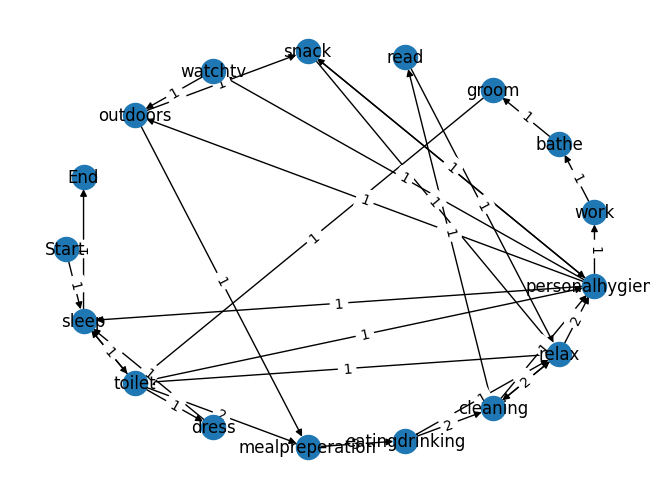

In [193]:
%autoreload
import src.xes.analyze_sequence

sequence = src.xes.analyze_sequence.analyze_sequence(
    df,
    sequence_keys=["concept:name"])
src.xes.analyze_sequence.draw_nx_graph(sequence)

In [194]:
sequence.nodes

NodeView(('Start', 'sleep', 'toilet', 'dress', 'mealpreperation', 'eatingdrinking', 'cleaning', 'relax', 'personalhygiene', 'work', 'bathe', 'groom', 'read', 'snack', 'watchtv', 'outdoors', 'End'))

In [198]:
print(next(node for node, data in sequence.nodes.items() if data.get("first")))
print(next(node for node, data in sequence.nodes.items() if data.get("last")))

Start
End


In [201]:
%autoreload
import src.xes.analyze_sequence
tree = src.xes.analyze_sequence.traverse_all_pathes(sequence, min_steps=5, max_steps=10)

In [202]:
tree

Tree node 'Start' (0x1372cb3b)

In [203]:
len(tree)

217

In [204]:
print(tree.get_ascii(attributes=["name", "frequency"]))


                                                                         /sleep, 1-End, 1
                                                                        |
                                                                /toilet, 3dress, 1sleep, 1-End, 1
                                                               |        |
                                                        /sleep, 1        \personalhygiene, 1sleep, 1-End, 1
                                                       |       |
                                                       |        \-End, 1
                                                       |
                                               /toilet, 3               /toilet, 3sleep, 1-End, 1
                                              |        |-dress, 1sleep, 1
                                              |        |                \-End, 1
                                              |        |
                                              |   

In [214]:
# tree.children[0].children[0].children[0].features
# import src.utils
[x for x in tree.children]

[Tree node 'sleep' (0x1375785f)]

In [233]:
def random_weighted_tree_path(tree: ete3.Tree):
    if len(tree.children) == 0:
        return [tree.name]

    choice_input = {node.name: node.frequency for node in tree.children}
    next_node_name = src.utils.choice(choice_input)
    next_node = next(child for child in tree.children if child.name == next_node_name)

    return [tree.name, *random_weighted_tree_path(next_node)]

random_weighted_tree_path(tree)

['Start',
 'sleep',
 'toilet',
 'personalhygiene',
 'snack',
 'relax',
 'toilet',
 'personalhygiene',
 'snack',
 'personalhygiene',
 'sleep',
 'End']

In [224]:
tree.children[0].features

{'dist', 'frequency', 'name', 'support'}

In [246]:
# circular_style = ete3.TreeStyle()
# circular_style.mode = "c"
# circular_style.scale = 20
# tree.render("tree.png", w=183, units="mm")
tree.render("t.svg")

ImportError: cannot import name 'TreeStyle' from 'ete3' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/ete3/__init__.py)

In [245]:
%autoreload
import ete3